# Imports

In [1]:
import time
start_time = time.time()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
sns.set_palette('muted')

from datetime import datetime

from tqdm import tqdm

from sklearn.model_selection import train_test_split

from sklearn.base import clone

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [3]:
DATA_PATH = '../data/equity-post-HCT-survival-predictions/'
RANDOM_STATE = 54321

# Data

In [4]:
sample_df = pd.read_csv(DATA_PATH + 'sample_submission.csv')
test_df = pd.read_csv(DATA_PATH + 'test.csv')

In [5]:
X = pd.read_pickle(DATA_PATH + 'train_test_split/X_25-12-2024.pkl')
y = pd.read_pickle(DATA_PATH + 'train_test_split/y_25-12-2024.pkl')
efs_time = pd.read_pickle(DATA_PATH + 'train_test_split/efs_time_25-12-2024.pkl')
race_group = pd.read_pickle(DATA_PATH + 'train_test_split/race_group_25-12-2024.pkl')

In [6]:
for col in X.columns:
    X[col] = X[col].ffill().bfill()

In [7]:
print(X.shape, y.shape, efs_time.shape, race_group.shape)

(28800, 81) (28800,) (28800,) (28800,)


## Risk Score

In [8]:
import pandas as pd

def normalize_min_max(value: pd.Series) -> pd.Series:
    return (value - value.min()) / (value.max() - value.min())

def composite_score(efs: pd.Series, efs_time: pd.Series, alpha: float = 0.5) -> pd.Series:
    score = alpha * efs + (1 - alpha) * (1 - efs_time)
    score = normalize_min_max(score)
    return score

In [9]:
risk_score = composite_score(y, efs_time)

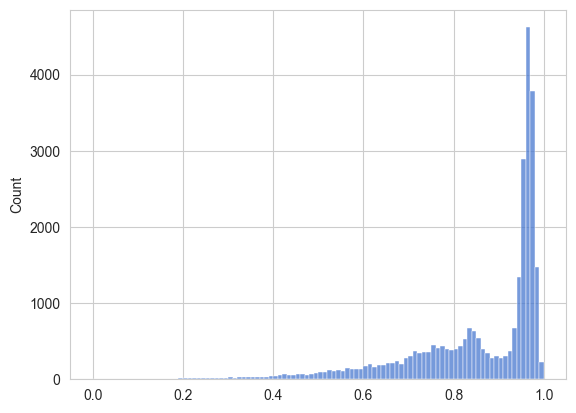

In [10]:
sns.histplot(risk_score, bins=100)
plt.show()

# Modeling

## Metric

In [11]:
import pandas as pd
import pandas.api.types
import numpy as np
from lifelines.utils import concordance_index

class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    >>> import pandas as pd
    >>> row_id_column_name = "id"
    >>> y_pred = {'prediction': {0: 1.0, 1: 0.0, 2: 1.0}}
    >>> y_pred = pd.DataFrame(y_pred)
    >>> y_pred.insert(0, row_id_column_name, range(len(y_pred)))
    >>> y_true = { 'efs': {0: 1.0, 1: 0.0, 2: 0.0}, 'efs_time': {0: 25.1234,1: 250.1234,2: 2500.1234}, 'race_group': {0: 'race_group_1', 1: 'race_group_1', 2: 'race_group_1'}}
    >>> y_true = pd.DataFrame(y_true)
    >>> y_true.insert(0, row_id_column_name, range(len(y_true)))
    >>> score(y_true.copy(), y_pred.copy(), row_id_column_name)
    0.75
    """
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    prediction_label = 'prediction'
    for col in submission.columns:
        if not pandas.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_list = []
    for race in merged_df_race_dict.keys():
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])
        metric_list.append(c_index_race)
    return float(np.mean(metric_list)-np.sqrt(np.var(metric_list)))

In [12]:
def score_wrapper(y_true, y_pred, efs_time, race_group):
    y_pred_dict = {
        'prediction': {i: pred for i, pred in enumerate(y_pred)}
    }        
    y_pred_dict = pd.DataFrame(y_pred_dict)
    y_pred_dict.insert(0, 'id', range(len(y_pred_dict)))
    
    y_true_dict = {
        'efs': {i: y for i, y in enumerate(y_true.values)},
        'efs_time': {i: t for i, t in enumerate(efs_time.values)},
        'race_group': {i: r for i, r in enumerate(race_group.values)},
    }
    y_true_dict = pd.DataFrame(y_true_dict)
    y_true_dict.insert(0, 'id', range(len(y_true_dict)))
    
    return score(y_true_dict.copy(), y_pred_dict.copy(), 'id')

def cross_validate(model, X, y, cv=10, scale=False):
    cv_scores = []
    
    for i in tqdm(range(cv)):
        test_idxs = list(range(int((len(X)*(i)/cv)), int((len(X)*(i+1)/cv))))
        
        X_train = X.drop(index=test_idxs)
        y_train = y.drop(index=test_idxs)
        
        X_test = X.iloc[test_idxs]
        y_test = y.iloc[test_idxs]
        
        if scale:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        
        model_copy = clone(model)
        
        model_copy.fit(X_train, y_train)
        y_pred = model_copy.predict(X_test)
        
        cv_scores.append(score_wrapper(
            y_test, 
            y_pred, 
            efs_time.iloc[test_idxs], 
            race_group.iloc[test_idxs]
        ))
    
    return np.mean(cv_scores)

## Model

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, risk_score, test_size=0.2, random_state=RANDOM_STATE)

In [14]:
lgbmreg = LGBMRegressor(verbose=-1, random_state=RANDOM_STATE)
cv_score = cross_validate(lgbmreg, X, risk_score, cv=5)
print(f'CV Score: {cv_score:.4f}')

100%|██████████| 5/5 [00:01<00:00,  2.76it/s]

CV Score: 0.6183


In [15]:
lgbmreg = LGBMRegressor(verbose=-1, random_state=RANDOM_STATE)
cv_score = cross_validate(lgbmreg, X, y, cv=5)
print(f'CV Score: {cv_score:.4f}')

100%|██████████| 5/5 [00:01<00:00,  2.58it/s]

CV Score: 0.6292


In [16]:
xgbreg = XGBRegressor(random_state=RANDOM_STATE)
cv_score = cross_validate(xgbreg, X, risk_score, cv=5)
print(f'CV Score: {cv_score:.4f}')

100%|██████████| 5/5 [00:01<00:00,  4.57it/s]

CV Score: 0.6102


In [17]:
xgbreg = XGBRegressor(random_state=RANDOM_STATE)
cv_score = cross_validate(xgbreg, X, y, cv=5)
print(f'CV Score: {cv_score:.4f}')

100%|██████████| 5/5 [00:01<00:00,  4.53it/s]

CV Score: 0.6218
